In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
from tensorflow.keras import layers

In [14]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/content/drive/MyDrive/data/skin_type/train/"
test_dir = "/content/drive/MyDrive/data/skin_type/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=16,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 93 images belonging to 3 classes.
Found 20 images belonging to 3 classes.


In [18]:
# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(3, activation="softmax")
])

In [19]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 108, 108, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 116640)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 349923    
Total params: 352,023
Trainable params: 352,023
Non-trainable params: 0
________________________________________________

In [20]:
# Compile our CNN
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
6/6 [==============================] - 3s 438ms/step - loss: 1.1414 - accuracy: 0.3978 - val_loss: 1.0819 - val_accuracy: 0.5500
Epoch 2/5
6/6 [==============================] - 2s 314ms/step - loss: 0.9834 - accuracy: 0.6344 - val_loss: 1.0574 - val_accuracy: 0.5000
Epoch 3/5
6/6 [==============================] - 2s 328ms/step - loss: 0.8421 - accuracy: 0.6989 - val_loss: 0.9767 - val_accuracy: 0.4000
Epoch 4/5
6/6 [==============================] - 2s 345ms/step - loss: 0.6516 - accuracy: 0.8495 - val_loss: 1.0686 - val_accuracy: 0.3500
Epoch 5/5
6/6 [==============================] - 2s 368ms/step - loss: 0.3948 - accuracy: 0.9140 - val_loss: 0.7640 - val_accuracy: 0.6500


In [27]:
import pathlib 
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['dry_skin' 'normal_skin' 'oil_skin']


In [30]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into (224,224,3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [48]:
# Reconfig pred_and_plot function to work with multi-class images
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Add in logic for multi-class & get pred_class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]
  
  print('Prediction Probabilities : ', pred[0])

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Prediction Probabilities :  [0.24323595 0.04742642 0.7093376 ]


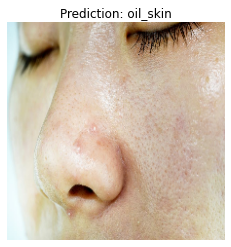

In [49]:
# Make a prediction using model_1
pred_and_plot(model=model_1, 
              filename="/content/close-up-of-a-womans-oily-skin.jpg", 
              class_names=class_names)